## Rock, Paper, Sissors 

In [ ]:
# fetch data
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /tmp/rps.zip
  
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /tmp/rps-test-set.zip

--2020-11-11 00:14:27--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.2.112, 172.253.63.128, 142.250.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.2.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 191.38M   247MB/s    in 0.8s    

2020-11-11 00:14:28 (247 MB/s) - ‘/tmp/rps.zip’ saved [200682221/200682221]

--2020-11-11 00:14:28--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.7.176, 172.217.12.240, 172.217.164.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.7.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘/tmp/rp

In [ ]:
# unzip
import os
import zipfile

local_zip = '/tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

local_zip = '/tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

rock_dir = os.path.join('/tmp/rps/rock')
paper_dir = os.path.join('/tmp/rps/paper')
scissors_dir = os.path.join('/tmp/rps/scissors')

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
print(rock_files[:10])

paper_files = os.listdir(paper_dir)
print(paper_files[:10])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:10])

total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock01-077.png', 'rock04-095.png', 'rock06ck02-071.png', 'rock03-059.png', 'rock06ck02-066.png', 'rock03-045.png', 'rock07-k03-067.png', 'rock01-009.png', 'rock03-086.png', 'rock04-119.png']
['paper04-113.png', 'paper03-011.png', 'paper04-063.png', 'paper01-042.png', 'paper06-070.png', 'paper02-005.png', 'paper06-057.png', 'paper03-106.png', 'paper01-027.png', 'paper05-094.png']
['scissors02-090.png', 'scissors03-033.png', 'testscissors02-055.png', 'testscissors02-006.png', 'scissors04-079.png', 'scissors03-097.png', 'scissors03-085.png', 'scissors01-036.png', 'scissors01-087.png', 'testscissors02-097.png']


### Look at photos

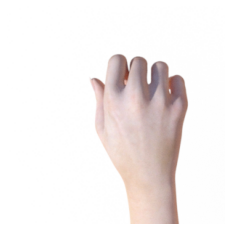

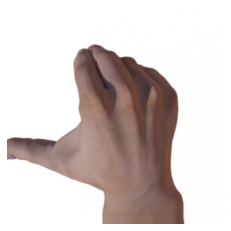

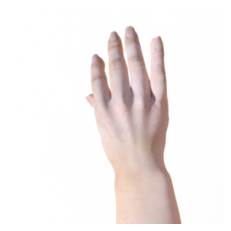

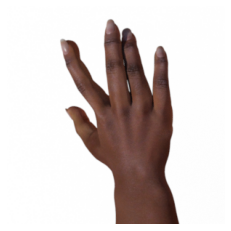

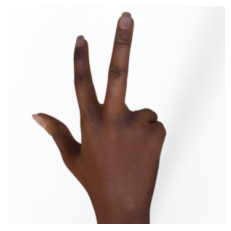

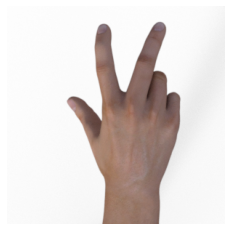

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_rock = [os.path.join(rock_dir, fname) 
                for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) 
                for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) 
                for fname in scissors_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

### ImageDataGenerator

In [ ]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/tmp/rps/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/tmp/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


### Build Model (& save model)

In [ ]:

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(train_generator, epochs=25, steps_per_epoch=20, validation_data = validation_generator, verbose = 1, validation_steps=3)




Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 128)      

### Plot Accuracy & Loss

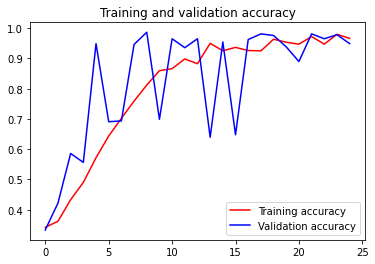

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()